In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import Metadata
import statistics
import math
import torch



In [244]:
columns = [
            "ID","Diagnosis","radius1","texture1","perimeter1","area1","smoothness1","compactness1",
            "concavity1","concave_points1","symmetry1","fractal_dimension1","radius2","texture2","perimeter2",
            "area2","smoothness2","compactness2","concavity2","concave_points2","symmetry2","fractal_dimension2",
            "radius3","texture3","perimeter3","area3","smoothness3","compactness3","concavity3","concave_points3",
            "symmetry3","fractal_dimension3"]
REAL_DATA = 0
SYNT_DATA = 1
ROUND = 5
torch.manual_seed(10)

In [245]:
def visualizeData(data,feature,plottype = "box"):
    index_array = np.arange(0,len(data),1)
    if plottype == "box":
        plt.figure(figsize=(3,3))
        plt.boxplot(data)
        plt.show()
    elif plottype == "hist":
        plt.figure(figsize=(3,3))
        plt.hist(data,bins=100, density=True)
        plt.show()
    elif plottype == "scatter":
        plt.figure(figsize=(3,3))
        plt.scatter(index_array, data)
        plt.show()
    elif plottype == "all":
        fig, axis = plt.subplots(3,1, figsize=(10,5))

        fig.suptitle(f"plots for {feature}")
        axis[0].boxplot(data)
        axis[0].set_title("Boxplot")

        axis[1].hist(data,bins = 100)
        axis[1].set_title("Histogram (Distribution)")

        axis[2].scatter(index_array, data)
        axis[2].set_title("Scatterplot")
        
    elif plottype == "norm":
        stats.probplot(data,dist="norm",plot=plt)
        plt.show()

In [246]:
data = pd.read_csv("breast+cancer+wisconsin+diagnostic/wdbc.data")
data.columns = columns
data["Diagnosis"] = data["Diagnosis"].map({"M":1, "B":0}) #Change values under col "Diagnosis" from (M,B) to (1,0).
data.drop(["ID"], axis=1,inplace=True)


In [247]:
# print(len(data))
train_size = math.ceil(len(data)*0.8)

train_data = data[:train_size] #from zero to train_size
test_data = data[train_size:] #from train_size to end



455
113


In [248]:
meta = Metadata.detect_from_dataframe(train_data)
GAN = CTGANSynthesizer(meta, epochs=8000)
GAN.fit(train_data)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [249]:
synthetic_data = GAN.sample(num_rows=len(test_data))

In [275]:
class Compare:
    def __init__(self, colname = None, synt_data = None, real_data = None):
        self.synt_data = synt_data
        self.real_data = real_data
        self.synt_data_correlation = None
        self.real_data_correlation = None
        self.cols = [
            "radius1","texture1","perimeter1","area1","smoothness1","compactness1",
            "concavity1","concave_points1","symmetry1","fractal_dimension1","radius2","texture2","perimeter2",
            "area2","smoothness2","compactness2","concavity2","concave_points2","symmetry2","fractal_dimension2",
            "radius3","texture3","perimeter3","area3","smoothness3","compactness3","concavity3","concave_points3",
            "symmetry3","fractal_dimension3"]
        self.wasser_list = []
        self.correlation_diff = None
    def set_real(self, real_data):
        self.real_data = real_data
        return None
    
    def set_synt(self, synt_data):
        self.synt_data = synt_data
        return None

    def box(self,colname):
        fig, axis = plt.subplots(2,1, figsize = (10,5))
        axis[0].boxplot(self.real_data[colname])
        axis[0].set_title("Real data")

        axis[1].boxplot(self.synt_data[colname])
        axis[1].set_title("synthetic data")


    def hist(self,colname):
        
        fig, axis = plt.subplots(3,1, figsize = (10,5), sharex=True, sharey=True)
        fig.suptitle(f"Historgram for {colname} (Z-score normalized)")

        axis[0].hist(stats.zscore(self.real_data[colname]),bins=100,color="blue")
        axis[0].legend(["Real data"])

        axis[1].hist(stats.zscore(self.synt_data[colname]),bins=100,color="red")
        axis[1].legend(["Synthetic Data"])

        axis[2].hist(stats.zscore(self.synt_data[colname]),color="red",bins=100, alpha = 0.5)
        axis[2].hist(stats.zscore(self.real_data[colname]),color="blue",bins=100, alpha = 0.5)
        axis[2].legend(["synthetic Data","Real Data"])

    def calculate_min_max_std_mean_med_wass(self, colname = None):

        
        mean_list = self.calculate_mean(colname) #STÄMMER 2d lista [MEAN REAL, MEAN SYNT] #1D-lista. distance för varje kolumn.
        std_list = self.calculate_std(colname) #STÄMMER 2d lista [STD REAL, STD SYNT]
        min_list = self.calculate_min(colname) #STÄMMER 2d lista [MIN REAL, MIN SYNT]
        max_list = self.calculate_max(colname) #STÄMMER 2d lista [MAX REAL, MAX SYNT]
        med_list = self.calculate_med(colname)
        wasserstein_list = self.calculate_wasserstein(colname)

        if colname == None:
            cols = self.cols
        else:
            cols = list(colname)
        
        print(f"Data           Mean           Median           std            min            max")
        for index,col in enumerate(cols):
            print(f"-----------------------{col}-----------------------------------")
            print(f"Real        {round(mean_list[index][REAL_DATA],ROUND)}   {round(std_list[index][REAL_DATA],ROUND)}  {round(med_list[index][REAL_DATA],ROUND)}  {round(min_list[index][REAL_DATA],ROUND)}  {round(max_list[index][REAL_DATA],ROUND)}  ")
            print(f"Synthetic   {round(mean_list[index][SYNT_DATA],ROUND)}   {round(std_list[index][SYNT_DATA],ROUND)}  {round(med_list[index][SYNT_DATA],ROUND)}  {round(min_list[index][SYNT_DATA],ROUND)}  {round(max_list[index][SYNT_DATA],ROUND)}  ")
            print(f"Difference  {round(abs(mean_list[index][SYNT_DATA]-mean_list[index][REAL_DATA]),ROUND)}   {round(abs(med_list[index][SYNT_DATA]-med_list[index][REAL_DATA]),ROUND)}  {round(abs(std_list[index][SYNT_DATA]-std_list[index][REAL_DATA]),ROUND)}   {round(abs(min_list[index][SYNT_DATA]-min_list[index][REAL_DATA]),ROUND)} {round(abs(max_list[index][SYNT_DATA]-max_list[index][REAL_DATA]),ROUND)}  ")
            print(f"Wasserstein distance : {round(wasserstein_list[index],ROUND)}")
    

    def calculate_wasserstein(self, colname = None):
        if colname == None:
            cols = self.cols
        else:
            cols = list(colname)


        wasser_list = []
        for col in cols:
            wasser_list.append(stats.wasserstein_distance(stats.zscore(self.real_data[col]) , stats.zscore(self.synt_data[col])))
        return wasser_list

    def box_wasserstein(self):
        
        wasser_list = self.calculate_wasserstein()
        print(len(wasser_list))
        plt.figure(figsize=(5,5))
        plt.boxplot(wasser_list)
        plt.title("Boxpot Wasserstein distances")
        plt.show()

    def calculate_mean(self,colname):
        if colname == None:
            cols = self.cols
        else:
            cols = list(colname)
        mean_list = []
        for col in cols:
            mean_list.append([self.real_data[col].mean(),self.synt_data[col].mean()])
                    
        return mean_list


    def calculate_std(self,colname):
        if colname == None:
            cols = self.cols
        else:
            cols = list(colname)
        std_list = []
        for col in cols:
            std_list.append([self.real_data[col].std(ddof = 0), self.synt_data[col].std(ddof = 0)])
        return std_list

        
    def calculate_min(self,colname):
        if colname == None:
            cols = self.cols
        else:
            cols = list(colname)
        min_list = []
        for col in cols:
            min_list.append([self.real_data[col].min(), self.synt_data[col].min()])
        return min_list


    def calculate_med(self, colname):

        if colname == None:
            cols = self.cols
        else:
            cols = list(colname)
        med_list = []
        for col in cols:
            med_list.append([self.real_data[col].median(), self.synt_data[col].median()])
                    
        return med_list


    def calculate_max(self,colname):
        if colname == None:
            cols = self.cols
        else:
            cols = list(colname)
        max_list = []
        for col in cols:
            max_list.append([self.real_data[col].max(), self.synt_data[col].max()])
        return max_list

    def mean_wasser(self):
        wasser_list = self.calculate_wasserstein()
        print(round(statistics.mean(wasser_list),ROUND))
    
    def scatter_plot(self, colname):
        index_array = np.arange(0,len(self.real_data[colname]),1)
        fig, axis = plt.subplots(3,1, figsize = (10,5), sharex=True, sharey=True)
        fig.suptitle(f"Scatterplots for real vs. synthetic data")
        axis[0].scatter(index_array, self.real_data[colname], color="blue", alpha=1)
        
        axis[1].scatter(index_array, self.synt_data[colname], color = "red", alpha=1)

        axis[2].scatter(index_array, self.real_data[colname], color = "blue", alpha=0.5)
        axis[2].scatter(index_array, self.synt_data[colname], color = "red", alpha=0.5)
        

    def calculate_correclations_real(self):
        self.real_data_correlation = self.real_data.corr(method = "pearson")
        plt.matshow(self.real_data_correlation, cmap = "coolwarm", vmin = -1 , vmax = 1)
        plt.title("Feature Correlation Real-world data")
        plt.colorbar()
        plt.show()
    
    def calculate_correclations_synt(self):
        self.synt_data_correlation = self.synt_data.corr(method = "pearson")
        plt.matshow(self.synt_data_correlation, cmap = "coolwarm", vmin = -1, vmax = 1)
        plt.title("Feature Correlation Synthetic data")
        plt.colorbar()
        plt.show()

    def calculate_correlation_diff(self):
        self.correlation_diff = self.real_data_correlation - self.synt_data_correlation
        plt.matshow(self.correlation_diff, cmap = "seismic", vmin = -2, vmax = 2)
        plt.title("Difference Feature Correlation")
        plt.colorbar()
        plt.show()

        new = np.array(self.correlation_diff).flatten()

        print(f"The mean value of feature correlation error is: {round(new.mean(),ROUND)}")


    def calculate_mean_of_all_diff(self, colname = None):

        mean_list = self.calculate_mean(colname) #STÄMMER 2d lista [MEAN REAL, MEAN SYNT] #1D-lista. distance för varje kolumn.
        std_list = self.calculate_std(colname) #STÄMMER 2d lista [STD REAL, STD SYNT]
        min_list = self.calculate_min(colname) #STÄMMER 2d lista [MIN REAL, MIN SYNT]
        max_list = self.calculate_max(colname) #STÄMMER 2d lista [MAX REAL, MAX SYNT]
        med_list = self.calculate_med(colname)
        wasserstein_list = self.calculate_wasserstein(colname)

        diff_mean = []
        diff_med = []
        diff_std = []
        diff_min = []
        diff_max = []
        if colname == None:
            cols = self.cols
        else:
            cols = list(colname)
            
        for index,col in enumerate(cols):
            diff_mean.append(round(abs(mean_list[index][SYNT_DATA]-mean_list[index][REAL_DATA]),ROUND))   
            diff_med.append(round(abs(med_list[index][SYNT_DATA]-med_list[index][REAL_DATA]),ROUND)) 
            diff_std.append(round(abs(std_list[index][SYNT_DATA]-std_list[index][REAL_DATA]),ROUND))
            diff_min.append(round(abs(min_list[index][SYNT_DATA]-min_list[index][REAL_DATA]),ROUND))
            diff_max.append(round(abs(max_list[index][SYNT_DATA]-max_list[index][REAL_DATA]),ROUND)) 

        print(f"mean of differences in mean:{round(statistics.mean(diff_mean),ROUND)}")
        print(f"mean of difference medians:{round(statistics.mean(diff_med),ROUND) }")
        print(f"mean of difference std:{round(statistics.mean(diff_std),ROUND)}")
        print(f"mean of difference min:{round(statistics.mean(diff_min),ROUND)}")
        print(f"mean of difference max:{round(statistics.mean(diff_max),ROUND)}")



        fig, axis = plt.subplots(2,2, figsize = (10,5), sharex=True, sharey=False)
        fig.suptitle(f"Boxplots showing differences between Real and synthetic data")

        axis[0,0].boxplot(diff_mean)
        axis[0,0].title.set_text("Differences in Mean")

        axis[1,0].boxplot(diff_std)
        axis[1,0].title.set_text("Differences in stdv")

        axis[1,1].boxplot(diff_min)
        axis[1,1].title.set_text("Differences in min")

        axis[0,1].boxplot(diff_max)
        axis[0,1].title.set_text("Differences in Max")
        
    def calculate_median_of_all_diff(self, colname = None):

        mean_list = self.calculate_mean(colname) #STÄMMER 2d lista [MEAN REAL, MEAN SYNT] #1D-lista. distance för varje kolumn.
        std_list = self.calculate_std(colname) #STÄMMER 2d lista [STD REAL, STD SYNT]
        min_list = self.calculate_min(colname) #STÄMMER 2d lista [MIN REAL, MIN SYNT]
        max_list = self.calculate_max(colname) #STÄMMER 2d lista [MAX REAL, MAX SYNT]
        med_list = self.calculate_med(colname)
        wasserstein_list = self.calculate_wasserstein(colname)

        diff_mean = []
        diff_med = []
        diff_std = []
        diff_min = []
        diff_max = []
        if colname == None:
            cols = self.cols
        else:
            cols = list(colname)
            
        for index,col in enumerate(cols):
            diff_mean.append(round(abs(mean_list[index][SYNT_DATA]-mean_list[index][REAL_DATA]),ROUND))   
            diff_med.append(round(abs(med_list[index][SYNT_DATA]-med_list[index][REAL_DATA]),ROUND)) 
            diff_std.append(round(abs(std_list[index][SYNT_DATA]-std_list[index][REAL_DATA]),ROUND))
            diff_min.append(round(abs(min_list[index][SYNT_DATA]-min_list[index][REAL_DATA]),ROUND))
            diff_max.append(round(abs(max_list[index][SYNT_DATA]-max_list[index][REAL_DATA]),ROUND)) 

        print(f"median of differences in mean:{round(statistics.median(diff_mean),ROUND)}")
        print(f"median of difference medians:{round(statistics.median(diff_med),ROUND) }")
        print(f"median of difference std:{round(statistics.median(diff_std),ROUND)}")
        print(f"median of difference min:{round(statistics.median(diff_min),ROUND)}")
        print(f"median of difference max:{round(statistics.median(diff_max),ROUND)}")



        fig, axis = plt.subplots(2,2, figsize = (10,5), sharex=True, sharey=False)
        fig.suptitle(f"Boxplots showing differences between Real and synthetic data")

        axis[0,0].boxplot(diff_mean)
        axis[0,0].title.set_text("Differences in Mean")

        axis[1,0].boxplot(diff_std)
        axis[1,0].title.set_text("Differences in stdv")

        axis[1,1].boxplot(diff_min)
        axis[1,1].title.set_text("Differences in min")

        axis[0,1].boxplot(diff_max)
        axis[0,1].title.set_text("Differences in Max")
    
    

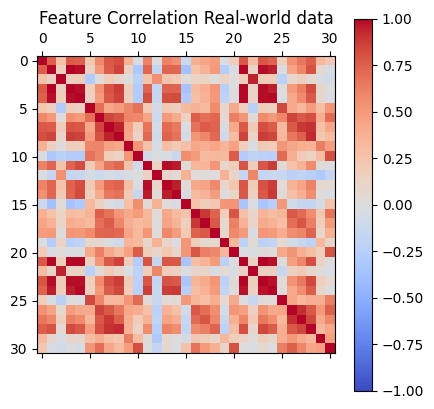

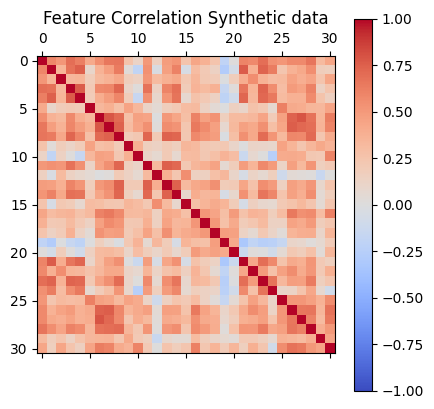

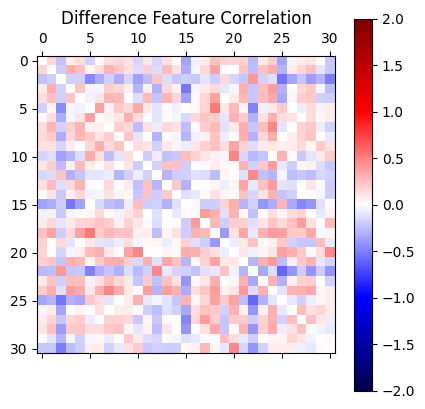

0.0179


In [276]:


cp = Compare(real_data=test_data,synt_data=synthetic_data)
# cp.calculate_min_max_std_mean_med_wass()
# cp.box_wasserstein()
# cp.mean_wasser()
# cp.calculate_wasserstein()
cp.calculate_correclations_real()
cp.calculate_correclations_synt()
cp.calculate_correlation_diff()
# cp.calculate_mean_of_all_diff()
# cp.calculate_median_of_all_diff()
# cp.hist("compactness1")